### María Sofía Álvarez - Brenda Barahona - Álvaro Plata

<h1 align='center'>Proyecto 1: Analítica de textos</h1>

## Instalación de librerías
<b><font color='blue'>Importante:</font></b> Correr antes de ejecutar el notebook. Con una única vez que se corra, basta.

In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install -U git+https://github.com/neomatrix369/nlp_profiler.git@master
#!pip install wordcloud

  Running command git clone -q https://github.com/neomatrix369/nlp_profiler.git 'C:\Users\brend\AppData\Local\Temp\pip-req-build-laevz8ue'


  Cloning https://github.com/neomatrix369/nlp_profiler.git (to revision master) to c:\users\brend\appdata\local\temp\pip-req-build-laevz8ue
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached en_core_web_sm-2.3.0-py3-none-any.whl


## Importación de librerías
Importamos las librerías necesarias para el desarrollo de este proyecto

In [2]:
# ESAI
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nlp_profiler.core import apply_text_profiling
from sklearn.model_selection import train_test_split, GridSearchCV

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%matplotlib inline

Las historias médicas describen las condiciones actuales de un paciente. Los médicos rutinariamente escanean docenas o cientos de historias clínicas en un solo día mientras hacen sus turnos en un hospital y deben resaltar la información relevante de ellos para poder determinar la enfermedad que padece un paciente. El objetivo de este proyecto es, a partir de dichas historias clínicas dadas por los médicos, crear una herramienta que ayude en la identificación del problema/enfermedad que un paciente padece. Se busca que las predicciones realizadas sean bastante precisas, pues los pacientes deben ser tratados acorde con la enfermedad que padecen. 

A continuación, se leerá el conjunto de datos correspondiente. Este incluye historias clínicas de varios pacientes, con la información más relevante de sus enfermedades reportada por los médicos. Asimismo, para cada paciente se tiene la enfermedad que padece. De acuerdo con el diccionario, esta puede ser cualquiera de las siguientes 5 categorías: 
1. Neoplasms (Neoplasias).
2. Digestive system diseases (Enfermedades del sistema digestivo).
3. Nervous system diseases (Enfermedades del sistema nervioso).
4. Cardiovascular diseases (Enfermedades cardiovasculares).
5. General pathological conditions (Condiciones patológicas generales).

Es posible ver que se tiene un problema de clasificación multiclase. 

---
## 1. Entendimiento del problema
Lo primero que hacemos es cargar las librerías y el conjunto de datos, con el fin de entender las particularidades del problema que estamos enfrentando.
### 1.1 Perfilamiento de los datos
Procedemos, entonces, a ver los datos suministrados.

In [4]:
diagnoses =pd.read_csv('ApoyoDiagnosticoEstudiante/medical_text_clasificacion.csv')

In [5]:
print("Tamaño del conjunto de datos:", len(diagnoses))
diagnoses.sample(5)

Tamaño del conjunto de datos: 12000


,medical_abstracts,problems_described
5720,Control of hypertensive emergencies Although u...,5
3932,The effect of prolonged hypothermia on cardiac...,5
4690,The ileosigmoid knot. The ileosigmoid knot (IS...,5
8846,Goal attainment scaling and outcome measuremen...,3
7925,Delayed facial palsy following uncomplicated s...,5


Con esto, podemos ver una muestra de los datos. Aquí, nos damos cuenta que nuestro conjunto de datos consiste de dos columnas: "medical_abstracts", con las historias clínicas de los pacientes (escritas en inglés), y "problems_described", que es un número con la enfermedad padecida por el paciente, de acuerdo con lo descrito arriba y en concordancia con el diccionario.

Asimismo, vemos que tenemos 12000 historias clínicas.

In [6]:
print('Las categorías de las enfermedades son: {}'.format(sorted(diagnoses['problems_described'].unique())))

Las categorías de las enfermedades son: [1, 2, 3, 4, 5]


Lo primero que podemos revisar es si hay algún problema que no se encuentre en las categorías 1-5 definidas para las enfermedades. Como vemos, en este caso todas las categorías concuerdan con las definidas por el negocio. Asimismo, nos damos cuenta que la clasificación es multiclase y no multietiqueta: cada historia clínica tiene una única enfermedad asociada.

Ahora queremos ver si nuestro conjunto de datos tiene entradas nulas. Para ello, revisamos si hay historias clínicas que correspondan con la cadena vacía "" o con un sólo espacio " ". Se ve que no hay ninguna con estas características, pues obtenemos un <i>dataframe</i> vacío, como vemos en la celda a continuación. Podemos hacer también una revisión con el método <code>isna()</code> de <code>pandas</code>. Este indica si hay algún valor de los datos que tenga como valor <code>None</code> o <code>numpy.NaN</code>. Vemos entonces que nuestro conjunto de datos no tiene ni nulos, ni faltantes.

In [7]:
print(diagnoses.isna().sum())

medical_abstracts     0
problems_described    0
dtype: int64


In [8]:
vacias = diagnoses[(diagnoses['medical_abstracts'] == "") | (diagnoses['medical_abstracts'] == " ")]
print('La cantidad de de historias clínicas vacías es: {}'.format(len(vacias)))

La cantidad de de historias clínicas vacías es: 0


Asimismo, confirmamos que no hay historias clínicas duplicadas en el conjunto de datos:

In [9]:
duplicados = diagnoses[diagnoses.duplicated()]
print('Número de registros duplicados: {}'.format(len(duplicados)))

Número de registros duplicados: 0


Vemos entonces que la calidad de los datos, en el sentido de nulos y duplicados, es bastante buena.

Nos damos cuenta ahora de que sólo tenemos una variable explicativa (la historia clínica) y que la variable objetivo (target) es la enfermedad que padece el usuario. Así las cosas partimos el conjunto de datos entre los datos de entrenamiento y de test: esto es crucial, pues, tras entrenar el modelo, debemos validarlo con datos que este nunca había visto. De acuerdo con el libro de Géron <a href='#geron'>[1]</a>, una buena división entre datos de entrenamiento y test es 80% y 20%, respectivamente, y en consecuencia es la que usaremos para toda esta exploración.

In [10]:
X, Y = diagnoses['medical_abstracts'], diagnoses['problems_described']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=28)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma y la distribución de los textos de acuerdo con sus clases:

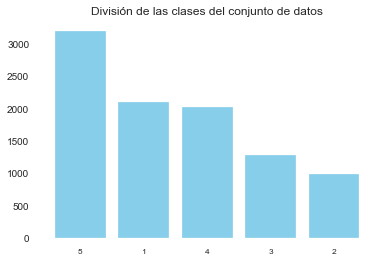

Veamos la cantidad de datos en cada clase: 


,problems_described
5,3194
1,2103
4,2029
3,1280
2,994


In [11]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='skyblue')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

print('Veamos la cantidad de datos en cada clase: ')
Y_train.value_counts().to_frame()

Podemos ver claramente que las clases están notablemente desbalanceadas. Vemos que la clase con más datos es la 5, lo cual es consecuente con el hecho de que esta es la clase más amplia, al tratar condiciones patológicas generales. Debemos clasificar todas las clases igual de bien, pues nos interesa conocer con precisión qué enfermedad posee cada paciente particular. Por esta razón, debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, usando técnicas de oversampling como SMOTE, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas (aunque esto depende de los algoritmos a utilizar, los cuales se definirán más adelante). Quisiéramos ver ambos comportamientos, entonces intentaremos explorar ambas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

---
Ya habiendo explorado la distribución de las clases, debido a que estamos haciendo análisis de textos, podemos usar analíticas de preprocesamiento diferentes a las que se han utilizado hasta el momento, como el <code>pandas profiling</code>. En este caso, utilizaremos una librería de código abierto, denominada <code>nlp profiler</code>, que permite resumir los datos de forma similar a la que lo haría la función <code>describe()</code> de <code>pandas</code> para datos numéricos. Este módulo permite el perfilamiento de datasets de textos y analizar diferentes propiedades de los datos. Asimismo, da información e _insights_ de alto nivel en los datos que se usarán <a href='#nlp_profiler'>[2]</a>.

Es importante notar que almacenaremos el resultado del perfilamiento en un archivo <code>csv</code> para fácil acceso cuando tenga que ejecutarse todo el proyecto; y, segundo, nos enfocaremos en analizar únicamente aquellas funcionalidades de <code>nlp profiler</code> que sean relevantes para este proyecto. Entonces:

In [12]:
# Importante: ¡Esta celda tarda mucho en ejecutarse!
#profile_data = apply_text_profiling(diagnoses, 'medical_abstracts')

# Importante: No correr esta linea si no se ha corrido la anterior.
#profile_data.to_csv('nlp_profiler_medical_abstracts.csv', index=False)

In [13]:
profile_data = pd.read_csv('nlp_profiler_medical_abstracts.csv')

#### Análisis de sentimientos: 
Podemos entender qué tan objetivas están siendo las historias clínicas escritas por los médicos. Vemos que la mayoría no son clasificadas ni como objetivas ni subjetivas (es decir, parecen ser bastante neutras), y la siguiente categoría corresponde a aquellas que son muy objetivas, como es de esperarse en un contexto médico.

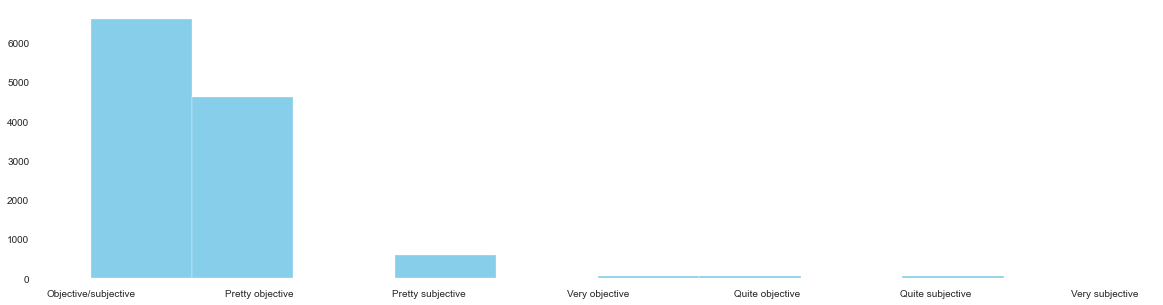

In [14]:
plt.figure(figsize=(20,5))
profile_data['sentiment_subjectivity'].hist(color='skyblue')
plt.grid()

#### Análisis de la calidad ortográfica:
Los desarrolladores de <code>nlp profile</code> utilizan el análisis de ortografía de Peter Norvig, el cual tiene una exactitud de 70% [3]. Podemos ver que, en general, nuestro dataset tiene buena ortografía, pues los puntajes se distribuyen entre 0.7 y 1, y tienen una media de 0.89.

La media de la calidad de ortografía es 0.89


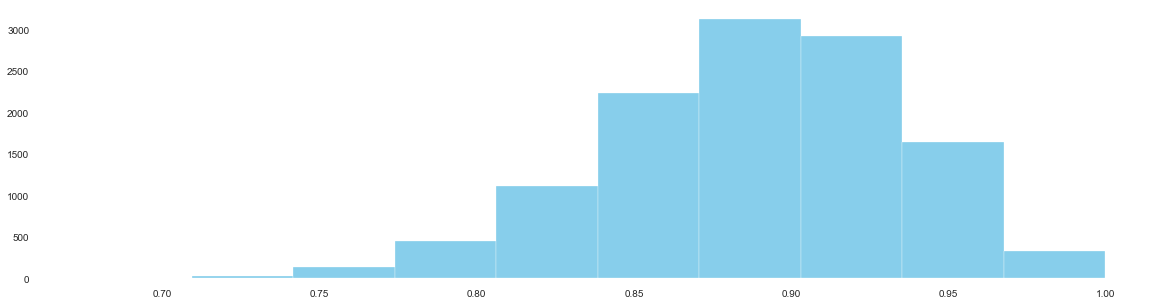

In [15]:
plt.figure(figsize=(20,5))
profile_data['spelling_quality_score'].hist(color='skyblue')
plt.grid()
print('La media de la calidad de ortografía es {:.2f}'.format(np.mean(profile_data['spelling_quality_score'])))

Lo anterior tiene sentido puesto que los datos provienen de historias clínicas: quienes las escribieron son médicos y, al ser parte de su ejercicio profesional (y no un tweet, por ejemplo) los datos deben tener mejor ortografía.

Finalmente, veamos algunas estadísticas finales sobre los textos:

In [16]:
print('Número de espacios repetidos:', profile_data['repeated_spaces_count'].unique())
print('Número de espacios en blanco repetidos: ', profile_data['repeated_whitespaces_count'].unique())
print('Número de caracteres no ingleses:', profile_data['non_english_characters_count'].unique())
print('Número de signos de puntuación repetidos:')
profile_data['repeated_punctuations_count'].value_counts().to_frame()

Número de espacios repetidos: [0]
Número de espacios en blanco repetidos:  [0]
Número de caracteres no ingleses: [0]
Número de signos de puntuación repetidos:


,repeated_punctuations_count
0,11539
1,250
2,109
7,37
8,20
3,15
6,12
4,8
5,5
9,2


Podemos ver que la calidad de los datos es, en este sentido, también bastante buena. No hay espacios repetidos, espacios en blanco repetidos, ni caracteres no ingleses. Ahora, es cierto que hay algunas oraciones con signos de puntuación repetidos. No obstante, son muy pocas y estos signos de puntuación serán eliminados en la fase de preprocesamiento.

---
Finalmente, podemos ver una nube con las palabras más populares sin nada de preprocesamiento aún:

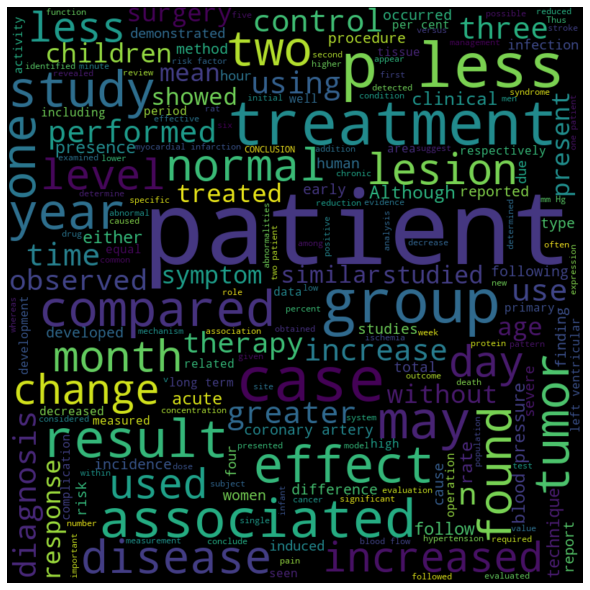

In [17]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data.values))                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud
wc = wordCloud_generator(X_train)
wc

En esta nube de palabras no hay mayores sorpresas: encontramos mayoritariamente términos que esperaríamos encontrar en historias clínicas. Note que las palabras: "patient", "tumor", "treatment", "study", "diagnosis" y "disease" resaltan. No obstante, note también que hay otras palabras irrelevantes como: "may", "use", "using", "used", e incluso algunas muy similares como "increase" e "increased". Todo esto será tratado más adelante en las fases de eliminación de stop words del inglés, lematización y demás partes del pre-procesamiento de lenguaje natural que se hará a continuación.

---
## 2. Pre-procesamiento de los datos

<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299

<a id='nlp_profiler'>[2]</a> https://towardsdatascience.com/nlp-profiler-profiling-datasets-with-one-or-more-text-columns-9b791193db89

[3] https://www.kaggle.com/code/neomatrix369/nlp-profiler-simple-dataset/notebook